This file trains the Linear and RNN models based on the hyperaparameters chosen during tuning. Models are trained for 150 epochs with early stopping. Results and comparisons are also produced from the trained models and testing set.<br>

Last updated: 4/15/2025

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from json import load
# PyTorch imports
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# Local imports
from tools import train_model, evaluate_model, calculate_R2_score, get_predictions, EarlyStopping, get_dataloaders
from models import SimpleNet, BaseballRNN

In [35]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [36]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

Use the pre-processed tensor files created by Data_preprocessing.ipynb. Dataset and dataloaders are used for both models. 80/10/10 train/test/validation split for dataloaders. Scaled using zero-mean scaling.

In [37]:
# Load saved tensor for inputs and targest
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

#  Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split and scale original dataset
train_dataset, valid_dataset, test_dataset = get_dataloaders(dataset)

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
torch.save(test_dataset, './datasets/test_dataset.pth')

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train inputs shape: torch.Size([57640, 9, 15]). Mean, Std: [0.0,1.0]
Valid inputs shape: torch.Size([7123, 9, 15]). Mean, Std: [-0.0,1.0]
Test inputs shape: torch.Size([7195, 9, 15]). Mean, Std: [-0.0,1.0]


# Linear model

In [ ]:
# Get best hyperparameters from tuning (Hyperparameter_tuning.ipynb)
with open('./tuning/mlp_best_params.json', 'r') as file:
    best_mlp_params = load(file)

# Load hyperparameters into variables
batch_size = int(best_mlp_params['batch_size'])
lr = best_mlp_params['lr']
grad_clip = best_mlp_params['grad_clip']
weight_decay = best_mlp_params['weight_decay']
hidden_size = int(best_mlp_params['hidden_size'])
mlp_dropout = best_mlp_params['mlp_dropout']

# Print hyperparameters
print("Best hyperparameters:")
for param in best_mlp_params:
    print(f"\t{param}: {best_mlp_params[param]}")

Best hyperparameters:
	batch_size: 16.0
	lr: 0.001
	mlp_dropout: 0.4
	weight_decay: 0.0001
	hidden_size: 16.0
	grad_clip: 2.0


### Training Loop

In [39]:
num_epochs = 150
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
input_size, seq_len = train_dataloader.dataset[0][0].shape
simple_baseball_mlp = SimpleNet(input_size=input_size, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and scheduler
optimizer = optim.Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training logs
mlp_log = []
mlp_eval_log = []
mlp_grads = []

# Loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=grad_clip)
    mlp_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=simple_baseball_mlp, dataloader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    mlp_eval_log.append(avg_valid_loss)

    # Track gradients across training
    grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
    mlp_grads.append(grads)

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 3,521


Training MLP:  13%|█▎        | 19/150 [02:44<18:52,  8.65s/it, Train loss=0.139, Validation loss=0.145, ES Counter=15]

Early stopping at epoch 19


### Results

In [40]:
# Evaluate model
mlp_test_RMSE = evaluate_model(model=simple_baseball_mlp, dataloader=test_dataloader, device=DEVICE, loss_fn='RMSE')
mlp_test_MSE = evaluate_model(model=simple_baseball_mlp, dataloader=test_dataloader, device=DEVICE, loss_fn='MSE')
mlp_test_MAE = evaluate_model(model=simple_baseball_mlp, dataloader=test_dataloader, device=DEVICE, loss_fn='MAE')

# Get predictions
mlp_targets, mlp_predictions = get_predictions(simple_baseball_mlp, test_dataloader, DEVICE)
mlp_test_r2 = calculate_R2_score(mlp_targets, mlp_predictions)

# Print results
print(f'Test RMSE: {mlp_test_RMSE:.4f}, Test MSE: {mlp_test_MSE:.4f}, Test MAE: {mlp_test_MAE:.4f}, Test R2: {mlp_test_r2:.2f}')

Test RMSE: 0.3715, Test MSE: 0.1404, Test MAE: 0.2827, Test R2: 0.02


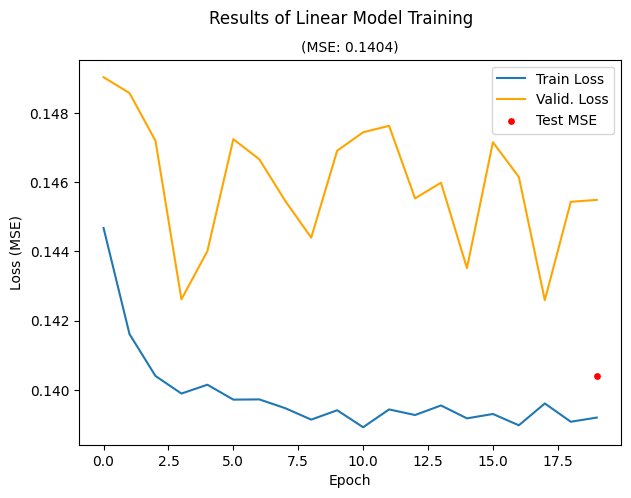

In [41]:
# Plot loss over time, final test stats
loss = 'MSE'
loss_val = mlp_test_MSE
plt.figure(figsize=(7, 5))
plt.suptitle("Results of Linear Model Training")
plt.title(f"({loss}: {loss_val:.4})", size=10)
plt.ylabel(f'Loss ({loss})')
plt.xlabel('Epoch')
plt.plot(mlp_log[:], label='Train Loss')
plt.plot(mlp_eval_log[:], label='Valid. Loss', color='orange')
plt.scatter(x=len(mlp_log)-1, y=loss_val, color='r', label=f"Test {loss}", s=15)
plt.legend()
plt.show()

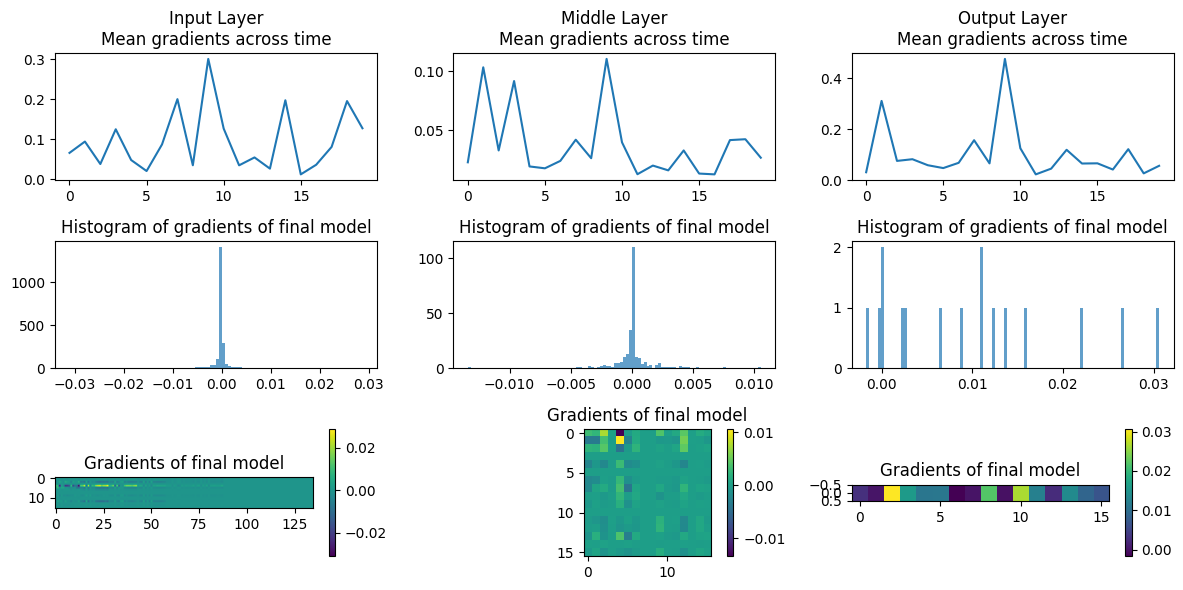

In [42]:
# If interesting, view the gradients across the three layers the final trianing.
input_layer_grad_norm = [torch.norm(mlp_grads[i]['input_layer.weight']).item() for i in range(len(mlp_grads))]
middle_layer_grad_norm = [torch.norm(mlp_grads[i]['middle_layer.weight']).item() for i in range(len(mlp_grads))]
output_layer_grad_norm = [torch.norm(mlp_grads[i]['output_layer.weight']).item() for i in range(len(mlp_grads))]

# Create a figure and subplots (3 row, 3 columns)
fig, axs = plt.subplots(3, 3, figsize=(12, 6))
axs[0, 0].plot(input_layer_grad_norm)
axs[0, 0].set_title('Input Layer\nMean gradients across time')
axs[0, 1].plot(middle_layer_grad_norm)
axs[0, 1].set_title('Middle Layer\nMean gradients across time')
axs[0, 2].plot(output_layer_grad_norm)
axs[0, 2].set_title('Output Layer\nMean gradients across time')

# Gradient histogram at end of training
i = 0
axs[1, 0].hist(grads['input_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 1].hist(grads['middle_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 2].hist(grads['output_layer.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 0].set_title('Histogram of gradients of final model')
axs[1, 1].set_title('Histogram of gradients of final model')
axs[1, 2].set_title('Histogram of gradients of final model')

# Gradients
grads = {n:p.grad.cpu() for n, p in simple_baseball_mlp.named_parameters()}
im1 = axs[2, 0].imshow(grads['input_layer.weight'])
im2 = axs[2, 1].imshow(grads['middle_layer.weight'])
im3 = axs[2, 2].imshow(grads['output_layer.weight'])
axs[2, 0].set_title('Gradients of final model')
axs[2, 1].set_title('Gradients of final model')
axs[2, 2].set_title('Gradients of final model')
fig.colorbar(im1, ax=axs[2, 0])
fig.colorbar(im2, ax=axs[2, 1])
fig.colorbar(im3, ax=axs[2, 2])

plt.tight_layout()
plt.show()

An investigation into feature importance, based on the values of the weights of the model. Note that inputs of the first layer are flattened, so that they are of shape variables x sequence length. So, while there might be 135 columns of the weight matrix, columns 0-14 correspond to the 15 input variables at the first sequence, columns 15-29 correspond to the input variables at the second sequence, and so on. For example (from w3resource.com):<br> <img src="https://www.w3resource.com/w3r_images/numpy-manipulation-ndarray-flatten-function-image-1.png" alt="Numpy flatten" width="10%">

In [43]:
# Get values of the weights of the three layers
for name, param in simple_baseball_mlp.named_parameters():
    if name == 'input_layer.weight':
        input_layer = param.detach().cpu()
    elif name == 'middle_layer.weight':
        middle_layer = param.detach().cpu()
    elif name == 'output_layer.weight':
        output_layer = param.detach().cpu()

# Get columns (features) with the highest magnitude across rows (sequences)
abs_arr = np.abs(input_layer.numpy())  # absolute value of array
column_sums = abs_arr.sum(axis=0)  # sum across rows for each column
# Get indices of the top 3 columns with the highest sums
top_indices = np.argsort(column_sums)[-3:][::-1]

# Given a list of features, what do these indices correspond to?
features = np.array(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'estimated_woba_by_pitch_type', 
            'cluster_label', 'n_thruorder_pitcher', 'balls', 'strikes'])

# Print these features
print("Top Columns by Weight Magnitude:")
for i in top_indices:
    f_i = i % len(features)
    print(f"Index: {i}: {features[f_i]} (Seq. {i//len(features)})")

Top Columns by Weight Magnitude:
Index: 9: estimated_woba_using_speedangle_zone_avg (Seq. 0)
Index: 10: estimated_woba_by_pitch_type (Seq. 0)
Index: 13: balls (Seq. 0)


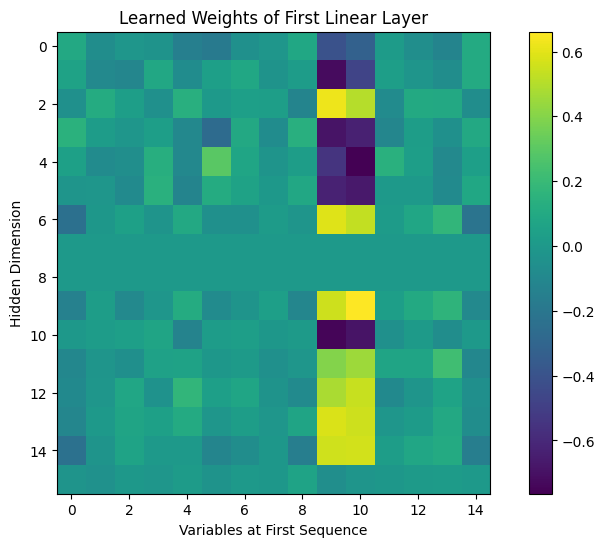

In [44]:
# Show the full picture and a zoomed in version of the weight values
plt.figure(figsize=(10, 6))
plt.imshow(input_layer[:, :15])
plt.colorbar()
plt.title("Learned Weights of First Linear Layer")
plt.ylabel("Hidden Dimension")
plt.xlabel("Variables at First Sequence")
plt.show()

Note that in the above image, only the first set of variables for the first sequence are shown. The result of the variables in other sequences do not have a large variance, so they are less interesting in this investigation. Furthermore, we can see that the majority of the weight values in other variable columns are close to zero, implying that they contribute far less to the final results of the model.

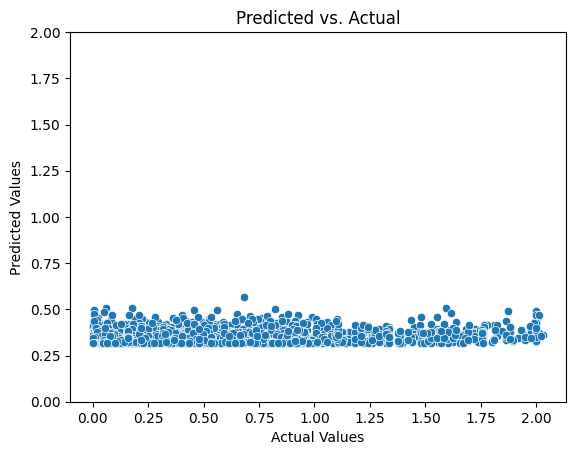

In [45]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=mlp_targets, y=mlp_predictions)
plt.ylim(0.0, 2.0)
plt.show()

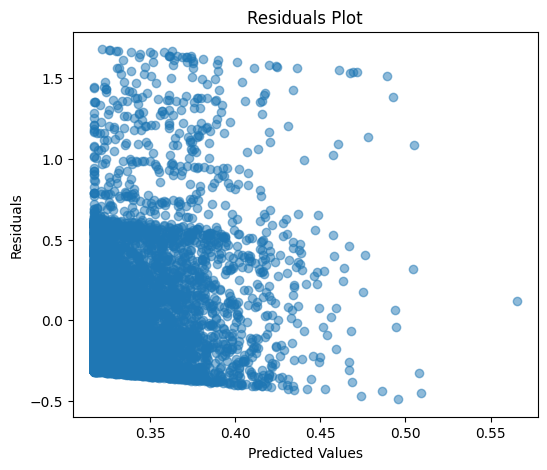

In [46]:
# Plot residuals
plt.figure(figsize=(6, 5))
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
residuals = np.array(mlp_targets) - np.array(mlp_predictions)
plt.scatter(mlp_predictions, residuals, alpha=0.5) 
plt.show()

# RNN model

In [47]:
# Get best hyperparameters from tuning
with open('./tuning/rnn_best_params.json', 'r') as file:
    rnn_best_params = load(file)

# Get best hyperparameters from tuning
batch_size = int(rnn_best_params['batch_size'])
lr = rnn_best_params['lr']
grad_clip = rnn_best_params['grad_clip']
weight_decay = rnn_best_params['weight_decay']
hidden_size = int(rnn_best_params['hidden_size'])
rnn_dropout = rnn_best_params['rnn_dropout']
n_layers = int(rnn_best_params['n_layers'])

# Print hyperparameters
# Print hyperparameters
print("Best hyperparameters:")
for param in rnn_best_params:
    print(f"\t{param}: {rnn_best_params[param]}")

Best hyperparameters:
	batch_size: 32.0
	n_layers: 3.0
	lr: 0.001
	rnn_dropout: 0.5
	weight_decay: 1e-05
	grad_clip: nan
	hidden_size: 16.0


### Training Loop

In [48]:
num_epochs = 150
early_stop_patience = 15

# Turn dataset into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Create model object
input_size = train_dataloader.dataset[0][0].size()[1]
baseball_rnn = BaseballRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers,
                            hidden_init='xavier', rnn_dropout=rnn_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in baseball_rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

# Training
rnn_log = []
rnn_eval_log = []
rnn_grads = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:
    # Get average loss over batches for training
    avg_train_loss = train_model(baseball_rnn, optimizer, train_dataloader, DEVICE, loss_fn='MSE', grad_clip=grad_clip)
    rnn_log.append(avg_train_loss)

    # Validation loss
    avg_valid_loss = evaluate_model(model=baseball_rnn, dataloader=valid_dataloader, device=DEVICE, loss_fn='MSE')
    rnn_eval_log.append(avg_valid_loss)

    # Track gradients across training
    grads = {n:p.grad.cpu() for n, p in baseball_rnn.named_parameters()}
    rnn_grads.append(grads)

    # Early Stopping
    early_stopper(avg_valid_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    # Update progress bar
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'ES Counter': early_stopper.counter})

Trainable parameters: 5,233


Training MLP:  36%|███▌      | 54/150 [04:36<08:11,  5.12s/it, Train loss=0.132, Validation loss=0.135, ES Counter=15]

Early stopping at epoch 54


### Results

In [49]:
# Evaluate model
rnn_test_RMSE = evaluate_model(model=baseball_rnn, dataloader=test_dataloader, device=DEVICE, loss_fn='RMSE')
rnn_test_MSE = evaluate_model(model=baseball_rnn, dataloader=test_dataloader, device=DEVICE, loss_fn='MSE')
rnn_test_accuracy_MAE = evaluate_model(model=baseball_rnn, dataloader=test_dataloader, device=DEVICE, loss_fn='MAE')
# Get predictions
rnn_targets, rnn_predictions = get_predictions(baseball_rnn, test_dataloader, DEVICE)
rnn_test_r2 = calculate_R2_score(rnn_targets, rnn_predictions)
# Print results
print(f'Test RMSE: {rnn_test_RMSE:.4f}, Test MSE: {rnn_test_MSE:.4f}, Test MAE: {rnn_test_accuracy_MAE:.4f} Test R2: {rnn_test_r2:.2f}')

Test RMSE: 0.3580, Test MSE: 0.1303, Test MAE: 0.2748 Test R2: 0.10


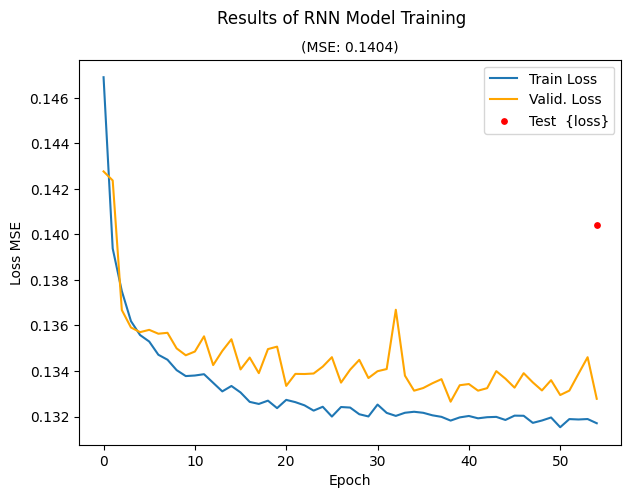

In [50]:
# Plot loss over time, final test stats
loss = 'MSE'
loss_val = mlp_test_MSE
plt.figure(figsize=(7, 5))
plt.suptitle("Results of RNN Model Training")
plt.title(f"({loss}: {loss_val:.4})", size=10)
plt.ylabel(f'Loss {loss}')
plt.xlabel('Epoch')
plt.plot(rnn_log[:], label='Train Loss')
plt.plot(rnn_eval_log[:], label='Valid. Loss', color='orange')
plt.scatter(x=len(rnn_log)-1, y=loss_val, color='r', label=r"Test  {loss}", s=15)
plt.legend()
plt.show()

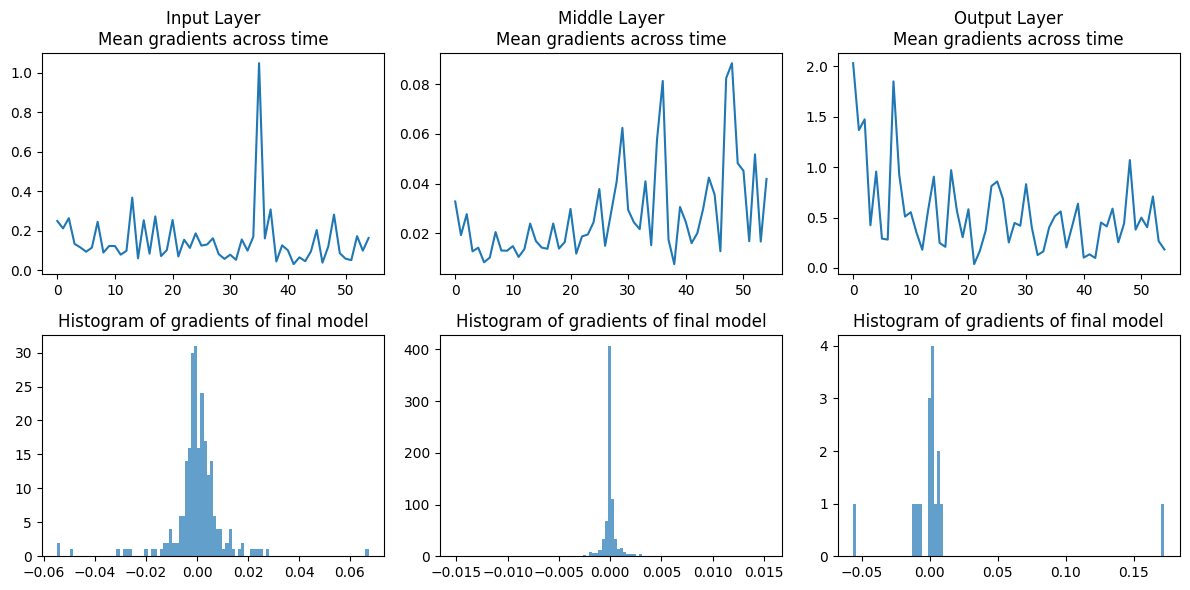

In [51]:
# If interesting, view the gradients across the three layers the final trianing.

input_layer_grad_norm = [torch.norm(rnn_grads[i]['fc_in.weight']).item() for i in range(len(rnn_grads))]
middle_layer_grad_norm = [torch.norm(rnn_grads[i]['rnn1.weight_hh_l0']).item() for i in range(len(rnn_grads))]
output_layer_grad_norm = [torch.norm(rnn_grads[i]['fc_out.weight']).item() for i in range(len(rnn_grads))]

# Create a figure and subplots (3 row, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs[0, 0].plot(input_layer_grad_norm)
axs[0, 0].set_title('Input Layer\nMean gradients across time')
axs[0, 1].plot(middle_layer_grad_norm)
axs[0, 1].set_title('Middle Layer\nMean gradients across time')
axs[0, 2].plot(output_layer_grad_norm)
axs[0, 2].set_title('Output Layer\nMean gradients across time')
# Gradient histogram at end of training
i = 0
grads = {n:p.grad.cpu() for n, p in baseball_rnn.named_parameters()}
axs[1, 0].hist(grads['fc_in.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 1].hist(grads['rnn1.weight_hh_l0'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 2].hist(grads['fc_out.weight'].flatten().cpu().numpy(), bins=100, alpha=0.7)
axs[1, 0].set_title('Histogram of gradients of final model')
axs[1, 1].set_title('Histogram of gradients of final model')
axs[1, 2].set_title('Histogram of gradients of final model')

plt.tight_layout()
plt.show()

In [52]:
# Get values of the weights of the three layers
for name, param in baseball_rnn.named_parameters():
    if name == 'fc_in.weight':
        rnn_input_layer = param.detach().cpu()
    elif name == 'fc_out.weight':
        rnn_output_layer = param.detach().cpu()

# Get columns (features) with the highest magnitude across rows (sequences)
abs_arr = np.abs(rnn_input_layer.numpy())  # absolute value of array
column_sums = abs_arr.sum(axis=0)  # sum across rows for each column
# Get indices of the top 3 columns with the highest sums
rnn_top_indices = np.argsort(column_sums)[-3:][::-1]

# Given a list of features, what do these indices correspond to?
features = np.array(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'estimated_woba_by_pitch_type', 
            'cluster_label', 'n_thruorder_pitcher', 'balls', 'strikes'])

# Print these features
print("Top Columns by Weight Magnitude:")
for i in rnn_top_indices:
    f_i = i % len(features)
    print(f"Index: {i}: {features[f_i]} (Seq. {i//len(features)})")

Top Columns by Weight Magnitude:
Index: 5: plate_x (Seq. 0)
Index: 9: estimated_woba_using_speedangle_zone_avg (Seq. 0)
Index: 10: estimated_woba_by_pitch_type (Seq. 0)


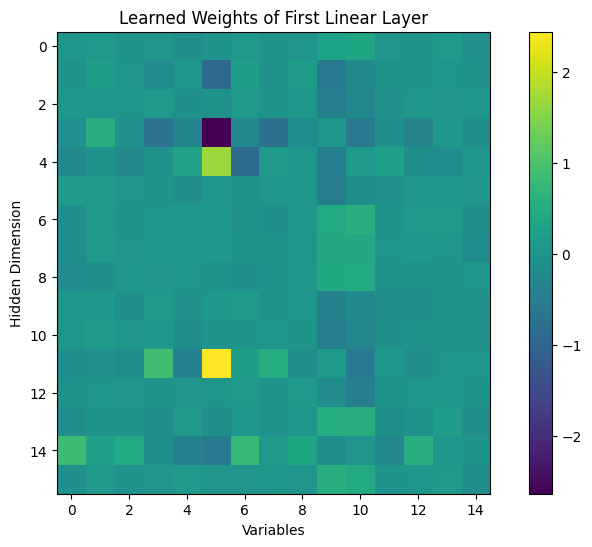

In [53]:
# Show the full picture and a zoomed in version of the weight values
plt.figure(figsize=(10, 6))
plt.imshow(rnn_input_layer[:, :])
plt.colorbar()
plt.title("Learned Weights of First Linear Layer")
plt.ylabel("Hidden Dimension")
plt.xlabel("Variables")
plt.show()

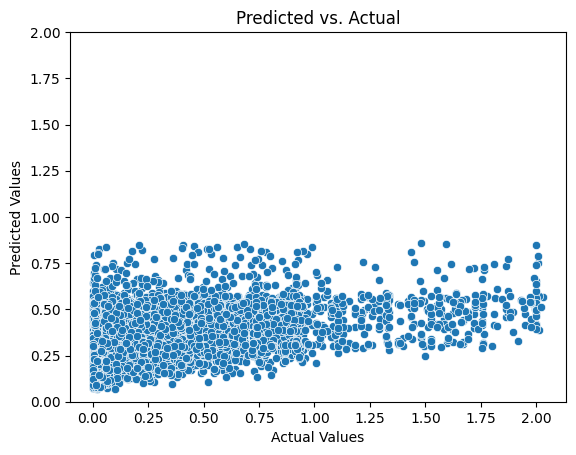

In [54]:
# Plot predicted vs. actual
plt.title("Predicted vs. Actual")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
sns.scatterplot(x=rnn_targets, y=rnn_predictions)
plt.ylim(0.0, 2.0)
plt.show()

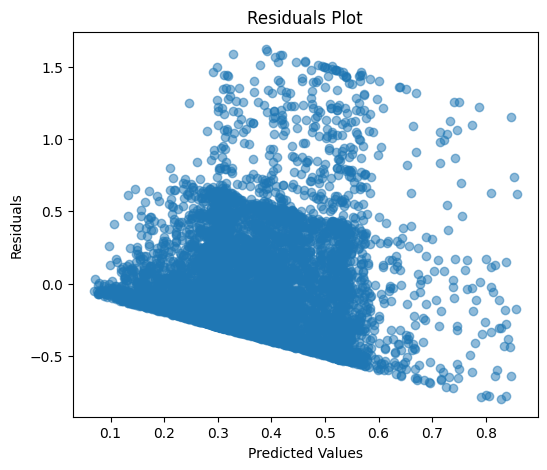

In [55]:
# Plot residuals
plt.figure(figsize=(6, 5))
plt.title("Residuals Plot")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
residuals = np.array(rnn_targets) - np.array(rnn_predictions)
plt.scatter(rnn_predictions, residuals, alpha=0.5) 
plt.show()

## Comparing Two models

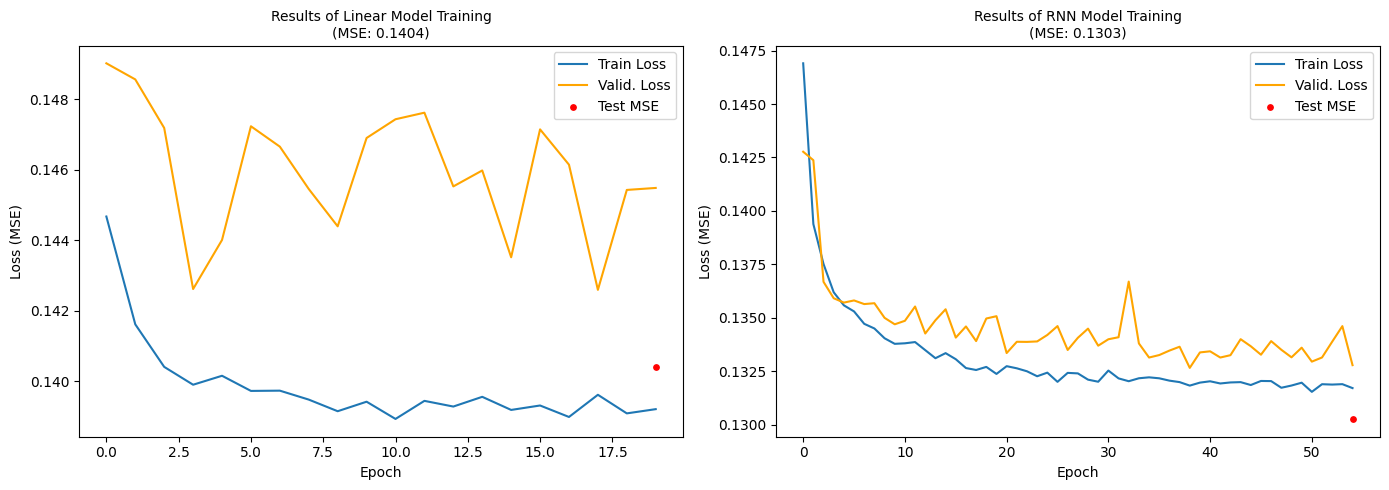

In [56]:
# Create a figure and axis objects for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
loss = 'MSE'
# Plot for the Linear Model Training
ax[0].set_title(f"Results of Linear Model Training\n({loss}: {mlp_test_MSE:.4})", fontsize=10)
ax[0].set_ylabel(f'Loss ({loss})')
ax[0].set_xlabel('Epoch')
ax[0].plot(mlp_log, label='Train Loss')
ax[0].plot(mlp_eval_log, label='Valid. Loss', color='orange')
ax[0].scatter(x=len(mlp_log)-1, y=mlp_test_MSE, color='r', label=f"Test {loss}", s=15)
ax[0].legend()

# Plot for the RNN Model Training
ax[1].set_title(f"Results of RNN Model Training\n({loss}: {rnn_test_MSE:.4})", fontsize=10)
ax[1].set_ylabel(f'Loss ({loss})')
ax[1].set_xlabel('Epoch')
ax[1].plot(rnn_log, label='Train Loss')
ax[1].plot(rnn_eval_log, label='Valid. Loss', color='orange')
ax[1].scatter(x=len(rnn_eval_log)-1, y=rnn_test_MSE, color='r', label=f"Test {loss}", s=15)
ax[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


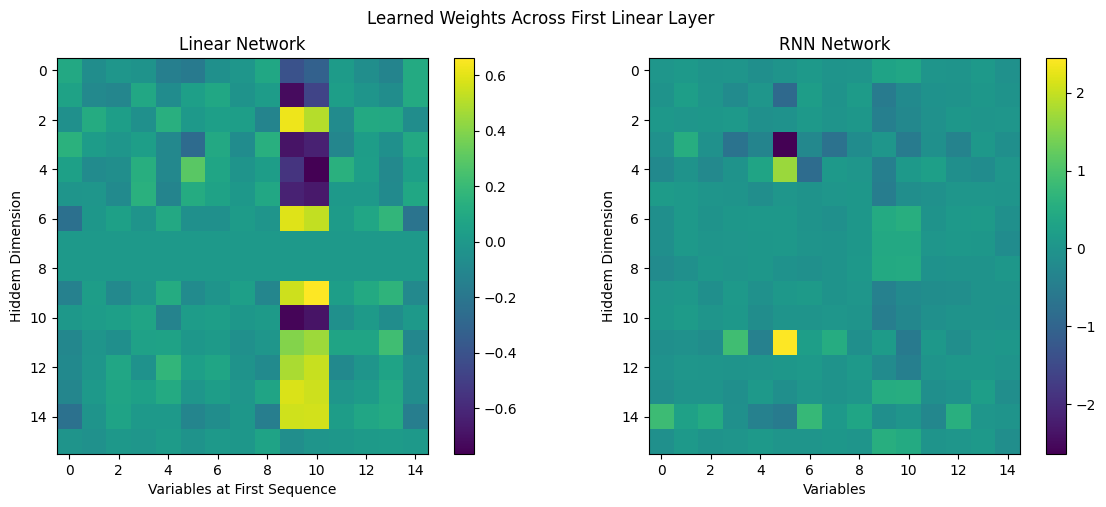

In [57]:
# Create a figure and axis objects for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for the Linear Model
im1 = ax[0].imshow(input_layer[:, :15])
ax[0].set_ylabel('Hiddem Dimension')
ax[0].set_xlabel('Variables at First Sequence')
ax[0].set_title("Linear Network")

# Plot for the RNN Model
im2 = ax[1].imshow(rnn_input_layer[:, :])
ax[1].set_ylabel('Hiddem Dimension')
ax[1].set_xlabel('Variables')
ax[1].set_title("RNN Network")

# Adjust layout and display
fig.suptitle("Learned Weights Across First Linear Layer")
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
plt.tight_layout()
plt.show()

## Test Evaluation

Showcase how to load models and make predictions using a testing set. Display the predicated values and plot the residuals of all models.

### XGBoost

In [58]:
import xgboost as xgb

# Load trained XGBoost model
best_model = xgb.XGBRegressor()
best_model.load_model('../models/xgboost_model.json')

# Load testing dataset
X_test = pd.read_csv('../models/X_test.csv', index_col=0)
y_test = pd.read_csv('../models/y_test.csv', index_col=0)

In [59]:
# Choose some random values from test set to predict against
inds = np.random.uniform(0, len(X_test), 1000).astype(int)

# Select these values
example_X_test = X_test.iloc[inds]
example_y_true = y_test.iloc[inds]

In [60]:
# Make predictions
example_y_pred = best_model.predict(example_X_test)

# Display predictions and results
print(f"{'True':<10}| {'XGBoost':<10}")
print("-" * 20) 
for i in range(10):
    print(f"{example_y_true.iloc[i].item():<10.3f}| {example_y_pred[i]:<10.3f}")


True      | XGBoost   
--------------------
1.480     | 0.434     
0.967     | 0.461     
0.182     | 0.314     
1.092     | 0.351     
1.011     | 0.416     
0.488     | 0.499     
0.518     | 0.540     
1.662     | 0.556     
0.088     | 0.171     
0.063     | 0.322     


### Neural Networks

In [61]:
# Choose some random values from test set to predict against
inds = np.random.uniform(0, len(test_dataset), 1000).astype(int)

# Select these values
example_input, example_target = test_dataset[list(inds)]
example_input, example_target = example_input.to(DEVICE), example_target.to(DEVICE)  # move to GPU

In [62]:
# Make predictions
simple_baseball_mlp.eval()
baseball_rnn.eval()
example_predictions_mlp = simple_baseball_mlp(example_input)
example_predictions_rnn = baseball_rnn(example_input)

# Display predictions and results
print(f"{'True':<10}| {'MLP':<10}| {'RNN':<10}")
print("-" * 30) 
for i in range(10):
    print(f"{example_target[i].item():<10.3f}| {example_predictions_mlp[i].item():<10.3f}| {example_predictions_rnn[i].item():<10.3f}")

True      | MLP       | RNN       
------------------------------
0.203     | 0.317     | 0.236     
0.827     | 0.317     | 0.307     
0.661     | 0.322     | 0.306     
0.455     | 0.325     | 0.372     
0.000     | 0.317     | 0.152     
0.216     | 0.317     | 0.219     
0.311     | 0.317     | 0.308     
0.024     | 0.346     | 0.511     
0.206     | 0.317     | 0.304     
0.049     | 0.319     | 0.296     


### Plot All Figures

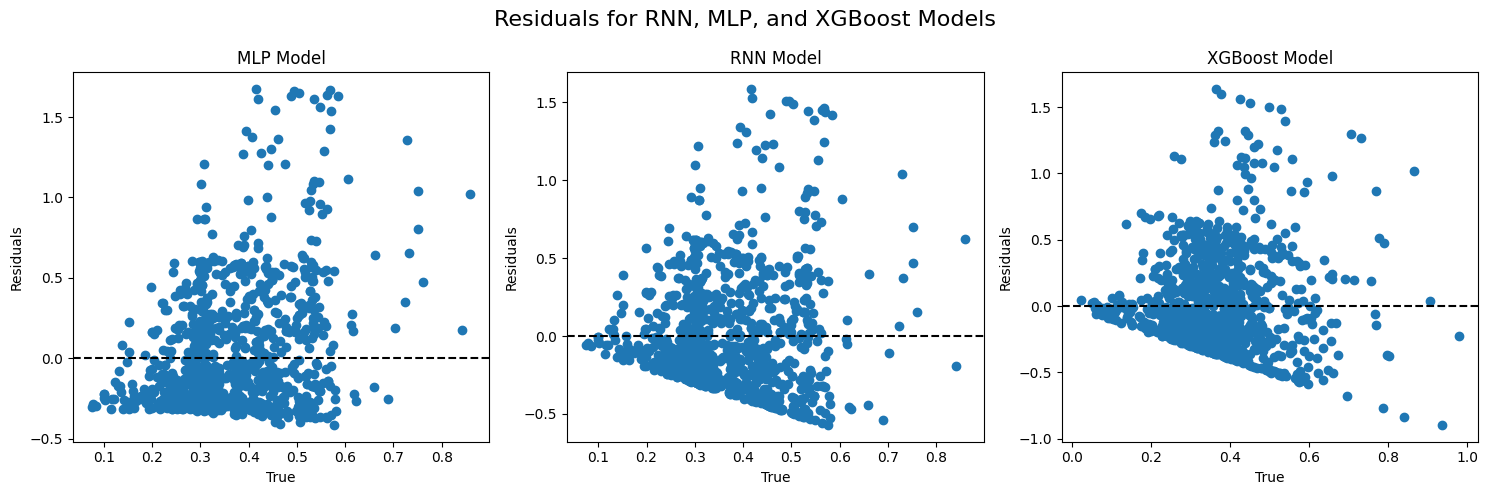

In [63]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

residuals_mlp = example_target.detach().cpu() - example_predictions_mlp.detach().cpu()
axs[0].scatter(example_predictions_rnn.detach().cpu(), residuals_mlp)
axs[0].set_title("MLP Model")
axs[0].set_xlabel("True")
axs[0].set_ylabel("Residuals")
axs[0].axhline(0, color='black', linestyle='--')

residuals_rnn = example_target.detach().cpu() - example_predictions_rnn.detach().cpu()
axs[1].scatter(example_predictions_rnn.detach().cpu(), residuals_rnn)
axs[1].set_title("RNN Model")
axs[1].set_xlabel("True")
axs[1].set_ylabel("Residuals")
axs[1].axhline(0, color='black', linestyle='--')

residuals_xgb = example_y_true.squeeze().to_numpy() - example_y_pred
axs[2].scatter(example_y_pred.squeeze(), residuals_xgb)
axs[2].set_title("XGBoost Model")
axs[2].set_xlabel("True")
axs[2].set_ylabel("Residuals")
axs[2].axhline(0, color='black', linestyle='--')

fig.suptitle("Residuals for RNN, MLP, and XGBoost Models", fontsize=16)

plt.tight_layout()
plt.show()